In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.nn.functional import cosine_similarity

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:


# Load data
train_data = torch.load('train.pt')
val_data = torch.load('val.pt')
test_data = torch.load('test.pt')

# Prepare dataset
def prepare_dataset(data):
    eeg_list = []
    stim_list = []
    for eeg, stim in data:
        eeg_list.append(eeg.float())           # (320, 64)
        stim_list.append(stim.float())         # (320,)
    eeg_tensor = torch.stack(eeg_list)         # (N, 320, 64)
    stim_tensor = torch.stack(stim_list)       # (N, 320)
    return eeg_tensor, stim_tensor

X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)



In [15]:
# Hyperparameters
hyperparameters = {
    # Data
    'fraction': 1,               # Use full dataset (as per your update)
    'batch_size': 32,              # Batch size for training, validation, and test
    # Model Architecture
    'cnn_filters': [32],           # Single CNN layer with 32 filters
    'cnn_kernel_size': (3, 3),     # Kernel size for CNN layer
    'cnn_padding': 1,              # Padding for CNN layer
    'lstm_hidden_size': 256,       # Increased hidden units per direction in LSTM
    'lstm_num_layers': 2,          # Number of LSTM layers
    'lstm_bidirectional': True,    # Whether LSTM is bidirectional
    'transformer_d_model': 512,    # Increased dimension of Transformer model
    'transformer_nhead': 4,        # Number of attention heads in Transformer
    'transformer_dim_feedforward': 1024,  # Increased feedforward dimension
    'transformer_num_layers': 1,   # Reduced to 1 Transformer encoder layer
    'transformer_dropout': 0.1,    # Dropout rate in Transformer
    'dropout_rate': 0.2,           # Dropout rate for CNN and LSTM
    # Training
    'num_epochs': 50,              # Increased from 5 to 50 epochs
    'learning_rate': 1e-4,         # Reduced learning rate for finer updates
    'loss_function': 'MSE',        # Reverted to Mean Squared Error
}

In [5]:
# Normalize data
def normalize_data(X, y):
    X_mean = X.mean(dim=(0, 1), keepdim=True)
    X_std = X.std(dim=(0, 1), keepdim=True)
    X_norm = (X - X_mean) / (X_std + 1e-8)
    y_min = y.min(dim=1, keepdim=True)[0]
    y_max = y.max(dim=1, keepdim=True)[0]
    y_norm = 2 * (y - y_min) / (y_max - y_min + 1e-8) - 1
    return X_norm, y_norm, X_mean, X_std, y_min, y_max

def denormalize_y(y_norm, y_min, y_max):
    return (y_norm + 1) / 2 * (y_max - y_min + 1e-8) + y_min

# Assume data is loaded as X_train, y_train, etc.
X_train_norm, y_train_norm, X_train_mean, X_train_std, y_train_min, y_train_max = normalize_data(X_train, y_train)
X_val_norm, y_val_norm, X_val_mean, X_val_std, y_val_min, y_val_max = normalize_data(X_val, y_val)
X_test_norm, y_test_norm, X_test_mean, X_test_std, y_test_min, y_test_max = normalize_data(X_test, y_test)


In [16]:
# Subsample training data
def subsample_data(X, y, fraction=hyperparameters['fraction']):
    n_samples = X.shape[0]
    n_subsample = max(1, int(n_samples * fraction))
    indices = np.random.permutation(n_samples)[:n_subsample]
    return X[indices], y[indices]

X_train_sub, y_train_sub = subsample_data(X_train_norm, y_train_norm)
print(f"Subsampled training data: X_train_sub {X_train_sub.shape}, y_train_sub {y_train_sub.shape}")


Subsampled training data: X_train_sub torch.Size([91381, 320, 64]), y_train_sub torch.Size([91381, 320])


In [17]:
# Create DataLoaders
train_dataset = TensorDataset(X_train_sub, y_train_sub)
val_dataset = TensorDataset(X_val_norm, y_val_norm)
test_dataset = TensorDataset(X_test_norm, y_test_norm)

train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'])

In [18]:
# Define the hybrid model with fixed residual connection
class EEG2EnvModel(nn.Module):
    def __init__(self):
        super(EEG2EnvModel, self).__init__()
        # Single CNN layer with residual connection
        self.cnn = nn.Sequential(
            nn.Conv2d(1, hyperparameters['cnn_filters'][0], kernel_size=hyperparameters['cnn_kernel_size'], 
                      padding=hyperparameters['cnn_padding']),
            nn.ReLU(),
            nn.BatchNorm2d(hyperparameters['cnn_filters'][0]),
            nn.Dropout(p=hyperparameters['dropout_rate'])
        )
        # Projection layer to match LSTM hidden size
        self.proj = nn.Linear(hyperparameters['cnn_filters'][0] * 64, hyperparameters['lstm_hidden_size'] * 2)
        self.lstm = nn.LSTM(input_size=hyperparameters['lstm_hidden_size'] * 2, 
                            hidden_size=hyperparameters['lstm_hidden_size'], 
                            num_layers=hyperparameters['lstm_num_layers'], 
                            batch_first=True, 
                            bidirectional=hyperparameters['lstm_bidirectional'])
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hyperparameters['transformer_d_model'], 
                nhead=hyperparameters['transformer_nhead'], 
                dim_feedforward=hyperparameters['transformer_dim_feedforward'], 
                dropout=hyperparameters['transformer_dropout']
            ),
            num_layers=hyperparameters['transformer_num_layers']
        )
        self.fc = nn.Linear(hyperparameters['transformer_d_model'], 1)

    def forward(self, x):
        x_original = x.unsqueeze(1)  # (N, 1, 320, 64)
        x = self.cnn(x_original)     # (N, 32, 320, 64)
        x = x.permute(0, 2, 1, 3).reshape(x.size(0), x.size(2), -1)  # (N, 320, 2048)
        x_proj = self.proj(x)        # Project to (N, 320, 512)
        lstm_out, _ = self.lstm(x_proj)  # (N, 320, 512)
        lstm_out = lstm_out + x_proj  # Residual connection (now compatible)
        x = self.transformer(lstm_out)  # (N, 320, 512)
        x = self.fc(x).squeeze(-1)   # (N, 320)
        return x

model = EEG2EnvModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])

# Metrics computation
def compute_metrics(y_true, y_pred):
    cosine_sims = []
    for i in range(y_true.shape[0]):
        cosine_sim = cosine_similarity(y_true[i].reshape(1, -1), y_pred[i].reshape(1, -1)).item()
        cosine_sims.append(cosine_sim)
    
    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    
    mse = mean_squared_error(y_true_np.flatten(), y_pred_np.flatten())
    mae = mean_absolute_error(y_true_np.flatten(), y_pred_np.flatten())
    
    pearson_corrs = []
    for i in range(y_true_np.shape[0]):
        pearson, _ = pearsonr(y_true_np[i], y_pred_np[i])
        pearson_corrs.append(pearson if not np.isnan(pearson) else 0.0)
    
    return mse, mae, np.mean(pearson_corrs), np.mean(cosine_sims), pearson_corrs, cosine_sims

/DATAHDD/chailex/anaconda3/envs/mtech_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [19]:
# Training and validation loop
train_losses = []
val_losses = []
val_pearsons = []
val_cosines = []

for epoch in range(hyperparameters['num_epochs']):
    model.train()
    train_loss = 0
    train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{hyperparameters["num_epochs"]} [Train]')
    for X_batch, y_batch in train_progress:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
        train_progress.set_postfix({'loss': loss.item()})
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0
    val_mse, val_mae, val_pearson, val_cosine = 0, 0, 0, 0
    val_progress = tqdm(val_loader, desc=f'Epoch {epoch+1}/{hyperparameters["num_epochs"]} [Val]')
    with torch.no_grad():
        for X_batch, y_batch in val_progress:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            mse, mae, pearson, cosine, _, _ = compute_metrics(y_batch, outputs)
            val_mse += mse
            val_mae += mae
            val_pearson += pearson
            val_cosine += cosine
            val_progress.set_postfix({'loss': loss.item()})
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_pearsons.append(val_pearson / len(val_loader))
    val_cosines.append(val_cosine / len(val_loader))
    
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Val MSE: {val_mse/len(val_loader):.4f}, Val MAE: {val_mae/len(val_loader):.4f}, '
          f'Val Pearson: {val_pearson/len(val_loader):.4f}, Val Cosine: {val_cosine/len(val_loader):.4f}')

Epoch 1/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.315]


Epoch 1: Train Loss: 0.2626, Val Loss: 0.2590, Val MSE: 0.2590, Val MAE: 0.4295, Val Pearson: 0.1364, Val Cosine: 0.5710


Epoch 2/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.332]


Epoch 2: Train Loss: 0.2564, Val Loss: 0.2627, Val MSE: 0.2628, Val MAE: 0.4263, Val Pearson: 0.1449, Val Cosine: 0.5723


Epoch 3/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.327]


Epoch 3: Train Loss: 0.2539, Val Loss: 0.2597, Val MSE: 0.2598, Val MAE: 0.4274, Val Pearson: 0.1522, Val Cosine: 0.5738


Epoch 4/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.328]


Epoch 4: Train Loss: 0.2510, Val Loss: 0.2581, Val MSE: 0.2582, Val MAE: 0.4261, Val Pearson: 0.1621, Val Cosine: 0.5761


Epoch 5/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.341]


Epoch 5: Train Loss: 0.2481, Val Loss: 0.2596, Val MSE: 0.2597, Val MAE: 0.4254, Val Pearson: 0.1633, Val Cosine: 0.5742


Epoch 6/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.334]


Epoch 6: Train Loss: 0.2449, Val Loss: 0.2605, Val MSE: 0.2605, Val MAE: 0.4250, Val Pearson: 0.1659, Val Cosine: 0.5755


Epoch 7/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.07it/s, loss=0.338]


Epoch 7: Train Loss: 0.2413, Val Loss: 0.2623, Val MSE: 0.2624, Val MAE: 0.4263, Val Pearson: 0.1618, Val Cosine: 0.5716


Epoch 8/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.336]


Epoch 8: Train Loss: 0.2373, Val Loss: 0.2633, Val MSE: 0.2634, Val MAE: 0.4263, Val Pearson: 0.1565, Val Cosine: 0.5714


Epoch 9/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.10it/s, loss=0.335]


Epoch 9: Train Loss: 0.2331, Val Loss: 0.2622, Val MSE: 0.2623, Val MAE: 0.4271, Val Pearson: 0.1572, Val Cosine: 0.5697


Epoch 10/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.339]


Epoch 10: Train Loss: 0.2291, Val Loss: 0.2680, Val MSE: 0.2681, Val MAE: 0.4302, Val Pearson: 0.1478, Val Cosine: 0.5638


Epoch 11/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.342]


Epoch 11: Train Loss: 0.2252, Val Loss: 0.2709, Val MSE: 0.2710, Val MAE: 0.4318, Val Pearson: 0.1458, Val Cosine: 0.5585


Epoch 12/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.344]


Epoch 12: Train Loss: 0.2211, Val Loss: 0.2775, Val MSE: 0.2776, Val MAE: 0.4329, Val Pearson: 0.1431, Val Cosine: 0.5542


Epoch 13/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.356]


Epoch 13: Train Loss: 0.2176, Val Loss: 0.2766, Val MSE: 0.2767, Val MAE: 0.4328, Val Pearson: 0.1398, Val Cosine: 0.5541


Epoch 14/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.371]


Epoch 14: Train Loss: 0.2141, Val Loss: 0.2803, Val MSE: 0.2804, Val MAE: 0.4328, Val Pearson: 0.1390, Val Cosine: 0.5554


Epoch 15/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.361]


Epoch 15: Train Loss: 0.2108, Val Loss: 0.2841, Val MSE: 0.2842, Val MAE: 0.4385, Val Pearson: 0.1341, Val Cosine: 0.5396


Epoch 16/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.365]


Epoch 16: Train Loss: 0.2076, Val Loss: 0.2902, Val MSE: 0.2903, Val MAE: 0.4415, Val Pearson: 0.1330, Val Cosine: 0.5328


Epoch 17/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.352]


Epoch 17: Train Loss: 0.2047, Val Loss: 0.2848, Val MSE: 0.2849, Val MAE: 0.4374, Val Pearson: 0.1318, Val Cosine: 0.5414


Epoch 18/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.36]


Epoch 18: Train Loss: 0.2020, Val Loss: 0.2869, Val MSE: 0.2870, Val MAE: 0.4369, Val Pearson: 0.1326, Val Cosine: 0.5450


Epoch 19/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.361]


Epoch 19: Train Loss: 0.1993, Val Loss: 0.2911, Val MSE: 0.2912, Val MAE: 0.4401, Val Pearson: 0.1289, Val Cosine: 0.5395


Epoch 20/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.343]


Epoch 20: Train Loss: 0.1968, Val Loss: 0.2845, Val MSE: 0.2845, Val MAE: 0.4398, Val Pearson: 0.1326, Val Cosine: 0.5382


Epoch 21/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.376]


Epoch 21: Train Loss: 0.1944, Val Loss: 0.2962, Val MSE: 0.2962, Val MAE: 0.4416, Val Pearson: 0.1258, Val Cosine: 0.5372


Epoch 22/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.376]


Epoch 22: Train Loss: 0.1921, Val Loss: 0.2988, Val MSE: 0.2989, Val MAE: 0.4461, Val Pearson: 0.1242, Val Cosine: 0.5228


Epoch 23/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.366]


Epoch 23: Train Loss: 0.1898, Val Loss: 0.2948, Val MSE: 0.2949, Val MAE: 0.4433, Val Pearson: 0.1261, Val Cosine: 0.5302


Epoch 24/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.38]


Epoch 24: Train Loss: 0.1877, Val Loss: 0.3010, Val MSE: 0.3011, Val MAE: 0.4458, Val Pearson: 0.1189, Val Cosine: 0.5247


Epoch 25/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.372]


Epoch 25: Train Loss: 0.1858, Val Loss: 0.2983, Val MSE: 0.2984, Val MAE: 0.4458, Val Pearson: 0.1189, Val Cosine: 0.5233


Epoch 26/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.372]


Epoch 26: Train Loss: 0.1838, Val Loss: 0.3002, Val MSE: 0.3003, Val MAE: 0.4485, Val Pearson: 0.1185, Val Cosine: 0.5135


Epoch 27/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.348]


Epoch 27: Train Loss: 0.1819, Val Loss: 0.2983, Val MSE: 0.2984, Val MAE: 0.4487, Val Pearson: 0.1157, Val Cosine: 0.5121


Epoch 28/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.383]


Epoch 28: Train Loss: 0.1802, Val Loss: 0.3074, Val MSE: 0.3075, Val MAE: 0.4511, Val Pearson: 0.1181, Val Cosine: 0.5119


Epoch 29/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.374]


Epoch 29: Train Loss: 0.1784, Val Loss: 0.2999, Val MSE: 0.3000, Val MAE: 0.4492, Val Pearson: 0.1184, Val Cosine: 0.5128


Epoch 30/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.38]


Epoch 30: Train Loss: 0.1766, Val Loss: 0.3083, Val MSE: 0.3084, Val MAE: 0.4512, Val Pearson: 0.1139, Val Cosine: 0.5141


Epoch 31/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.393]


Epoch 31: Train Loss: 0.1749, Val Loss: 0.3151, Val MSE: 0.3152, Val MAE: 0.4528, Val Pearson: 0.1203, Val Cosine: 0.5144


Epoch 32/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.372]


Epoch 32: Train Loss: 0.1735, Val Loss: 0.3036, Val MSE: 0.3037, Val MAE: 0.4496, Val Pearson: 0.1153, Val Cosine: 0.5136


Epoch 33/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.387]


Epoch 33: Train Loss: 0.1719, Val Loss: 0.3137, Val MSE: 0.3137, Val MAE: 0.4520, Val Pearson: 0.1148, Val Cosine: 0.5176


Epoch 34/50 [Val]: 100%|███████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.37]


Epoch 34: Train Loss: 0.1704, Val Loss: 0.3115, Val MSE: 0.3116, Val MAE: 0.4552, Val Pearson: 0.1166, Val Cosine: 0.4980


Epoch 35/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.386]


Epoch 35: Train Loss: 0.1690, Val Loss: 0.3147, Val MSE: 0.3148, Val MAE: 0.4550, Val Pearson: 0.1131, Val Cosine: 0.5078


Epoch 36/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.07it/s, loss=0.371]


Epoch 36: Train Loss: 0.1675, Val Loss: 0.3094, Val MSE: 0.3095, Val MAE: 0.4520, Val Pearson: 0.1147, Val Cosine: 0.5081


Epoch 37/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.07it/s, loss=0.384]


Epoch 37: Train Loss: 0.1661, Val Loss: 0.3183, Val MSE: 0.3183, Val MAE: 0.4558, Val Pearson: 0.1136, Val Cosine: 0.5079


Epoch 38/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.07it/s, loss=0.397]


Epoch 38: Train Loss: 0.1648, Val Loss: 0.3179, Val MSE: 0.3180, Val MAE: 0.4580, Val Pearson: 0.1111, Val Cosine: 0.4964


Epoch 39/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.382]


Epoch 39: Train Loss: 0.1636, Val Loss: 0.3152, Val MSE: 0.3152, Val MAE: 0.4553, Val Pearson: 0.1091, Val Cosine: 0.5052


Epoch 40/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.389]


Epoch 40: Train Loss: 0.1624, Val Loss: 0.3198, Val MSE: 0.3199, Val MAE: 0.4547, Val Pearson: 0.1155, Val Cosine: 0.5159


Epoch 41/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.399]


Epoch 41: Train Loss: 0.1611, Val Loss: 0.3240, Val MSE: 0.3240, Val MAE: 0.4605, Val Pearson: 0.1129, Val Cosine: 0.4928


Epoch 42/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.403]


Epoch 42: Train Loss: 0.1598, Val Loss: 0.3220, Val MSE: 0.3221, Val MAE: 0.4601, Val Pearson: 0.1094, Val Cosine: 0.4929


Epoch 43/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.10it/s, loss=0.397]


Epoch 43: Train Loss: 0.1586, Val Loss: 0.3206, Val MSE: 0.3207, Val MAE: 0.4581, Val Pearson: 0.1106, Val Cosine: 0.5001


Epoch 44/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.07it/s, loss=0.395]


Epoch 44: Train Loss: 0.1576, Val Loss: 0.3267, Val MSE: 0.3268, Val MAE: 0.4626, Val Pearson: 0.1079, Val Cosine: 0.4896


Epoch 45/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.395]


Epoch 45: Train Loss: 0.1563, Val Loss: 0.3253, Val MSE: 0.3254, Val MAE: 0.4617, Val Pearson: 0.1060, Val Cosine: 0.4903


Epoch 46/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.389]


Epoch 46: Train Loss: 0.1554, Val Loss: 0.3222, Val MSE: 0.3222, Val MAE: 0.4590, Val Pearson: 0.1090, Val Cosine: 0.4960


Epoch 47/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.392]


Epoch 47: Train Loss: 0.1543, Val Loss: 0.3255, Val MSE: 0.3256, Val MAE: 0.4636, Val Pearson: 0.1063, Val Cosine: 0.4805


Epoch 48/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.09it/s, loss=0.379]


Epoch 48: Train Loss: 0.1533, Val Loss: 0.3198, Val MSE: 0.3198, Val MAE: 0.4626, Val Pearson: 0.1066, Val Cosine: 0.4752


Epoch 49/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:40<00:00,  8.08it/s, loss=0.411]


Epoch 49: Train Loss: 0.1522, Val Loss: 0.3259, Val MSE: 0.3260, Val MAE: 0.4616, Val Pearson: 0.1086, Val Cosine: 0.4922


Epoch 50/50 [Val]: 100%|██████████████████████████████████████████████████| 328/328 [00:12<00:00, 26.60it/s, loss=0.393]

Epoch 50: Train Loss: 0.1512, Val Loss: 0.3276, Val MSE: 0.3277, Val MAE: 0.4634, Val Pearson: 0.1053, Val Cosine: 0.4858


In [20]:
# Test evaluation with batch indexing
model.eval()
test_pearsons = []
test_cosines = []
test_predictions = []
test_trues = []
batch_start_idx = 0
with torch.no_grad():
    test_progress = tqdm(test_loader, desc='Testing')
    for X_batch, y_batch in test_progress:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        # Get batch-specific min/max
        batch_size = X_batch.size(0)
        batch_indices = slice(batch_start_idx, batch_start_idx + batch_size)
        y_min_batch = y_test_min[batch_indices].to(device)
        y_max_batch = y_test_max[batch_indices].to(device)
        # Denormalize
        outputs_denorm = denormalize_y(outputs, y_min_batch, y_max_batch)
        y_batch_denorm = denormalize_y(y_batch, y_min_batch, y_max_batch)
        # Compute metrics on normalized data
        _, _, _, _, pearson_corrs, cosine_sims = compute_metrics(y_batch, outputs)
        test_pearsons.extend(pearson_corrs)
        test_cosines.extend(cosine_sims)
        test_predictions.append(outputs_denorm.cpu().numpy())
        test_trues.append(y_batch_denorm.cpu().numpy())
        test_progress.set_postfix({
            'pred_min': outputs_denorm.min().item(),
            'pred_max': outputs_denorm.max().item(),
            'true_min': y_batch_denorm.min().item(),
            'true_max': y_batch_denorm.max().item()
        })
        batch_start_idx += batch_size

test_predictions = np.concatenate(test_predictions)
test_trues = np.concatenate(test_trues)

Testing: 100%|████████| 788/788 [00:29<00:00, 26.53it/s, pred_min=0.0858, pred_max=1.14, true_min=0.0779, true_max=1.51]


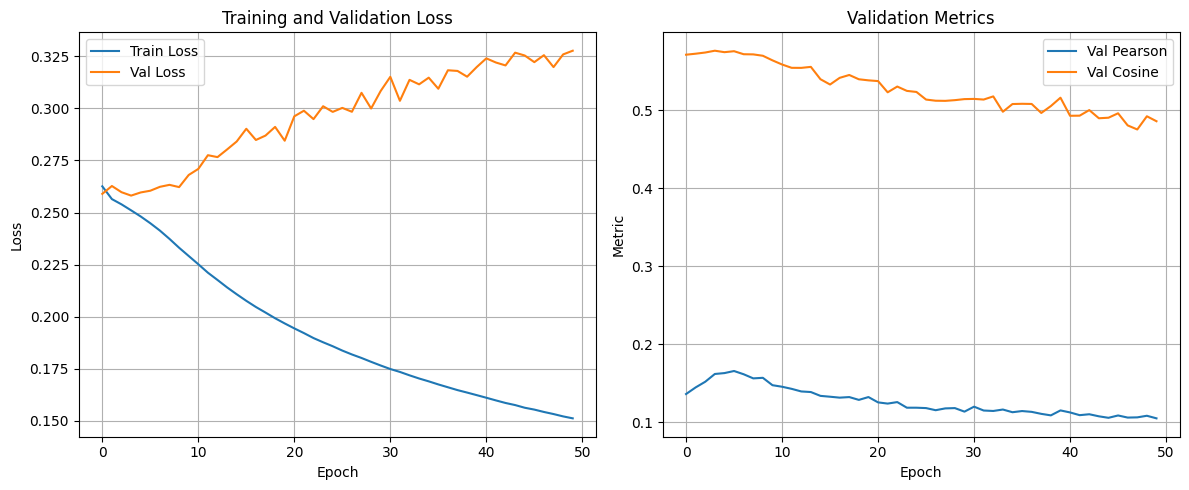

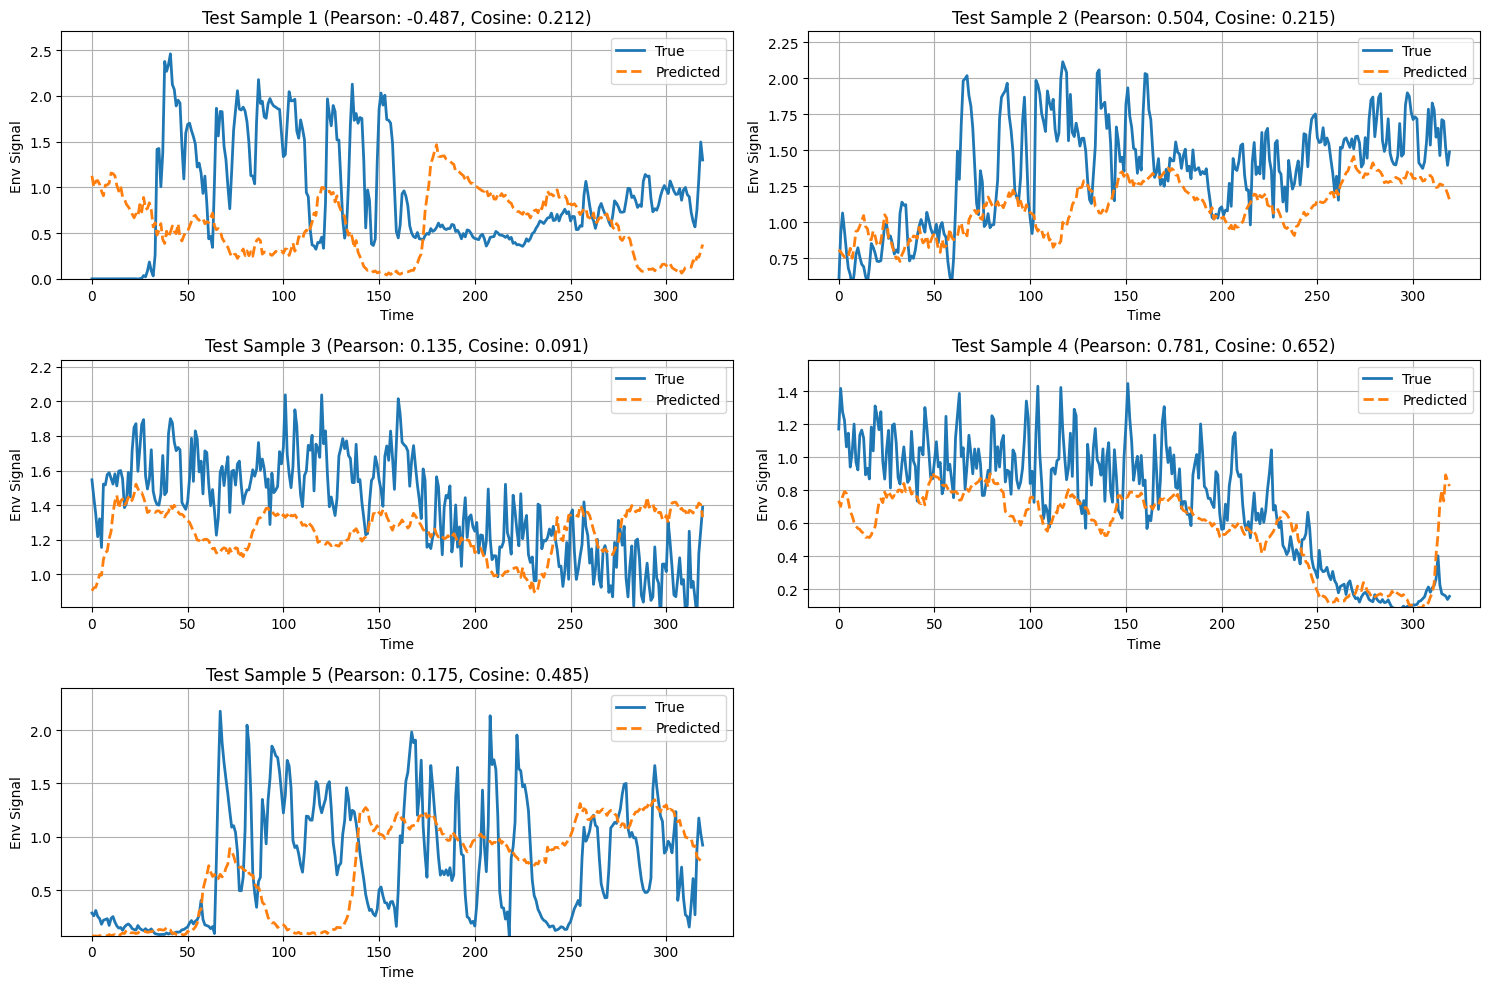

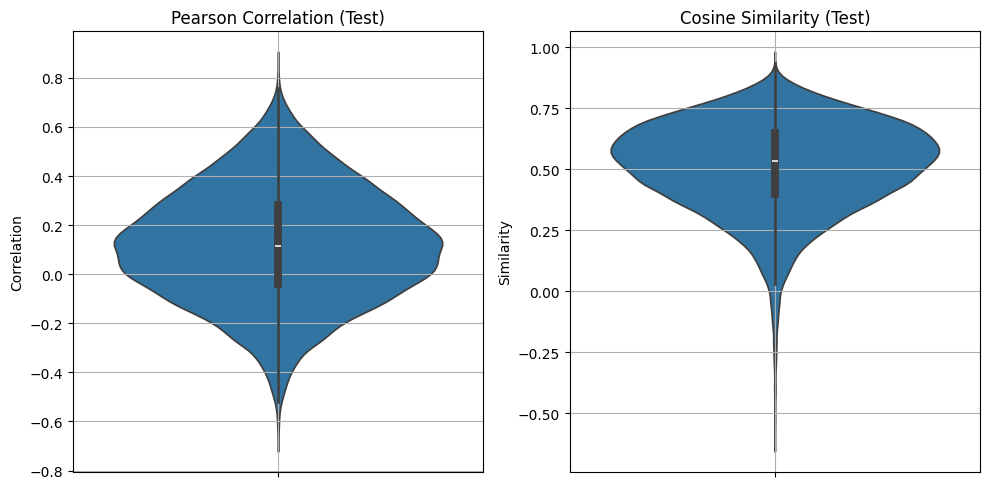

In [21]:
# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_pearsons, label='Val Pearson')
plt.plot(val_cosines, label='Val Cosine')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Validation Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Plot regression for 5 test samples
plt.figure(figsize=(15, 10))
for i in range(min(5, test_trues.shape[0])):
    plt.subplot(3, 2, i+1)
    plt.plot(test_trues[i], label='True', linewidth=2)
    plt.plot(test_predictions[i], label='Predicted', linestyle='--', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Env Signal')
    plt.title(f'Test Sample {i+1} (Pearson: {test_pearsons[i]:.3f}, Cosine: {test_cosines[i]:.3f})')
    plt.legend()
    plt.grid(True)
    y_min = min(test_trues[i].min(), test_predictions[i].min()) * 1.1
    y_max = max(test_trues[i].max(), test_predictions[i].max()) * 1.1
    plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig('regression_plots.png')
plt.show()

# Violin plots for test metrics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.violinplot(data=test_pearsons)
plt.title('Pearson Correlation (Test)')
plt.ylabel('Correlation')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.violinplot(data=test_cosines)
plt.title('Cosine Similarity (Test)')
plt.ylabel('Similarity')
plt.grid(True)
plt.tight_layout()
plt.savefig('violin_plots.png')
plt.show()